Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Loss: 0.2454
Epoch [2/30], Loss: 0.1741
Epoch [3/30], Loss: 0.1526
Epoch [4/30], Loss: 0.1479
Epoch [5/30], Loss: 0.1429
Epoch [6/30], Loss: 0.1388
Epoch [7/30], Loss: 0.1365
Epoch [8/30], Loss: 0.1323
Epoch [9/30], Loss: 0.1297
Epoch [10/30], Loss: 0.1272
Epoch [11/30], Loss: 0.1254
Epoch [12/30], Loss: 0.1240
Epoch [13/30], Loss: 0.1222
Epoch [14/30], Loss: 0.1205
Epoch [15/30], Loss: 0.1198
Epoch [16/30], Loss: 0.1196
Epoch [17/30], Loss: 0.1186
Epoch [18/30], Loss: 0.1180
Epoch [19/30], Loss: 0.1163
Epoch [20/30], Loss: 0.1156
Epoch [21/30], Loss: 0.1160
Epoch [22/30], Loss: 0.1152
Epoch [23/30], Loss: 0.1142
Epoch [24/30], Loss: 0.1125
Epoch [25/30], Loss: 0.1127
Epoch [26/30], Loss: 0.1125
Epoch [27/30], Loss: 0.1119
Epoch [28/30], Loss: 0.1119
Epoch [29/30], Loss: 0.1112
Epoch [30/30], Loss: 0.1103


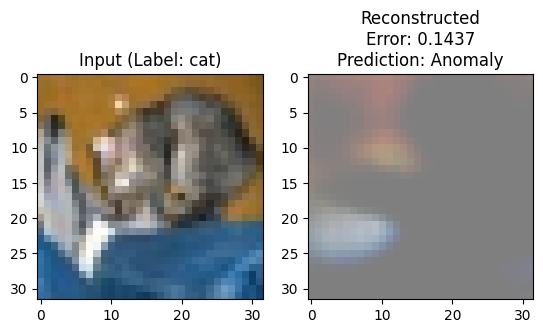

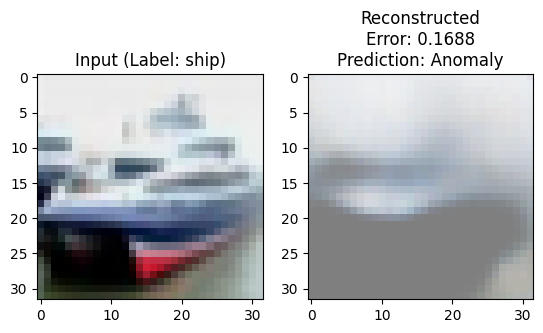

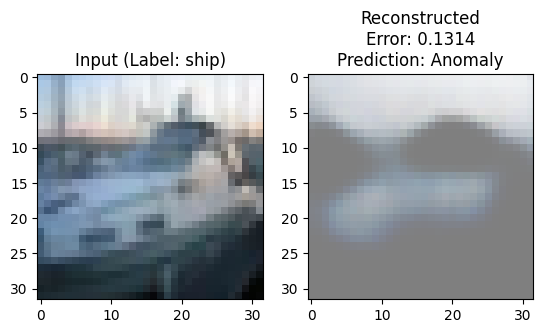

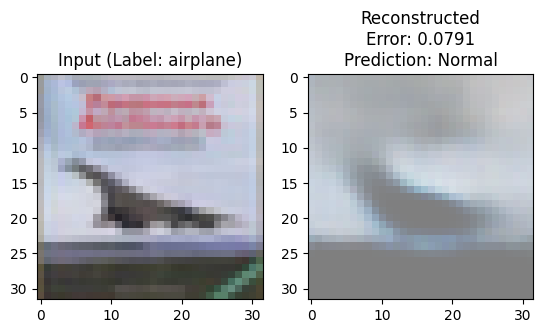

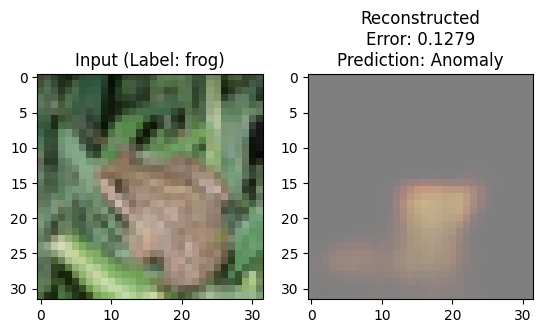

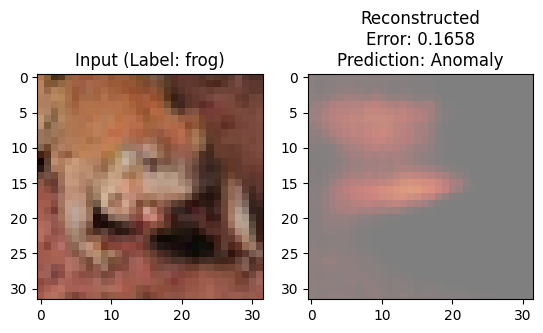

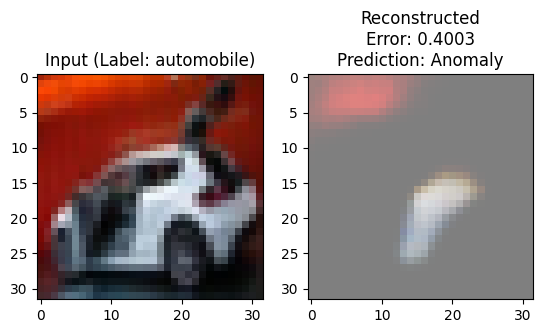

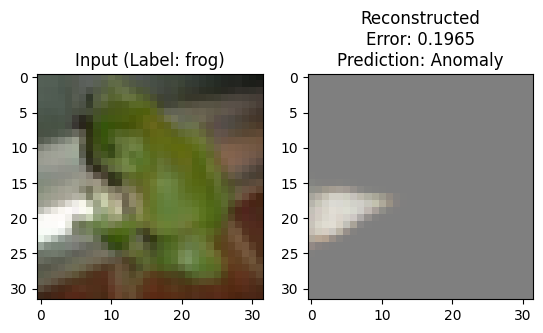

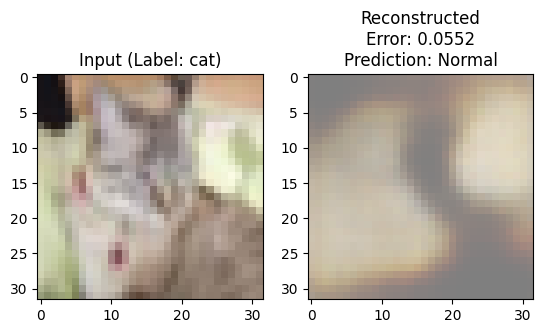

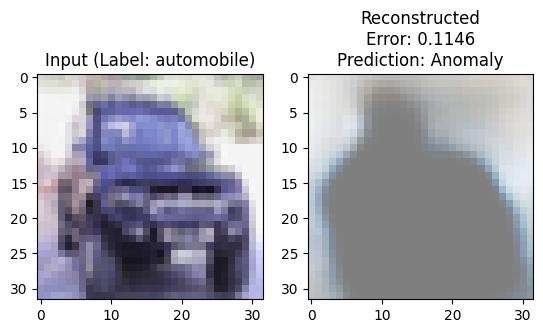

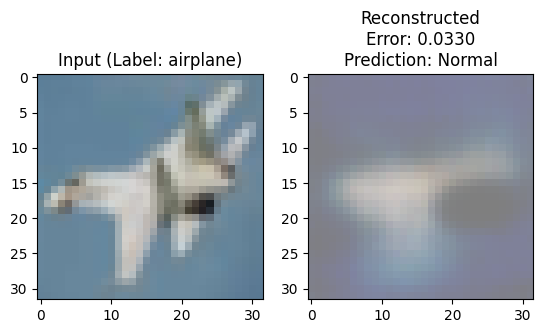

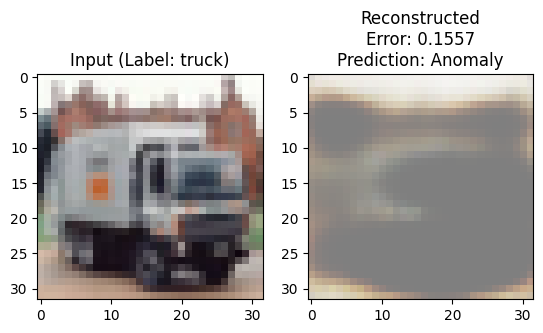

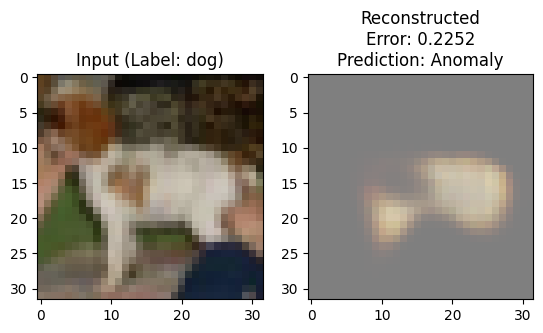

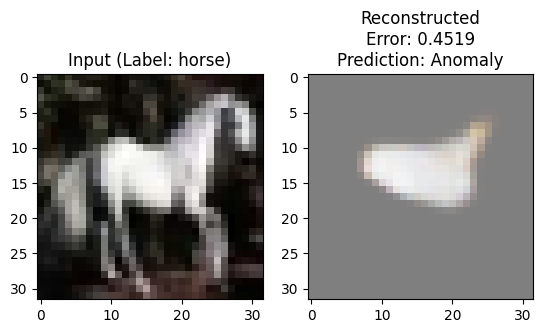

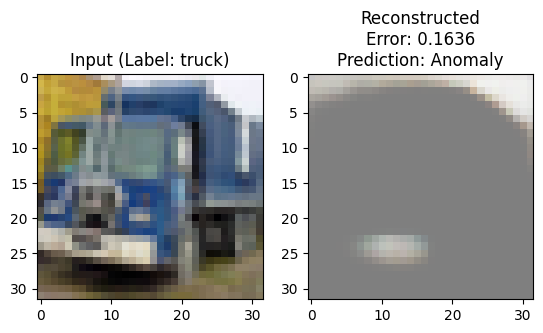

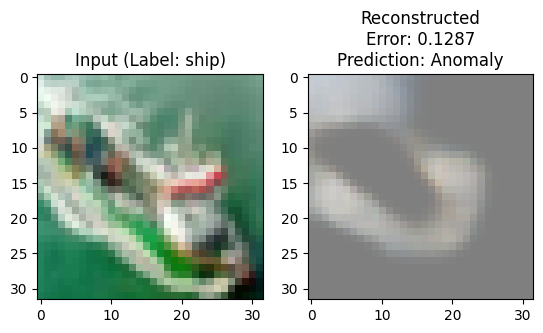

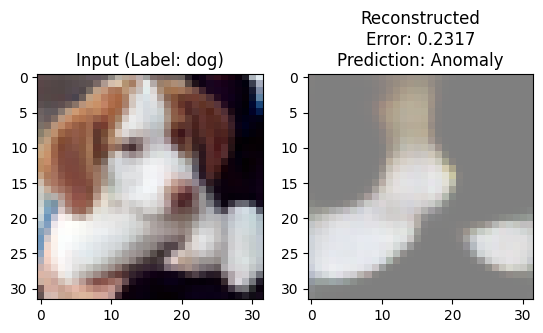

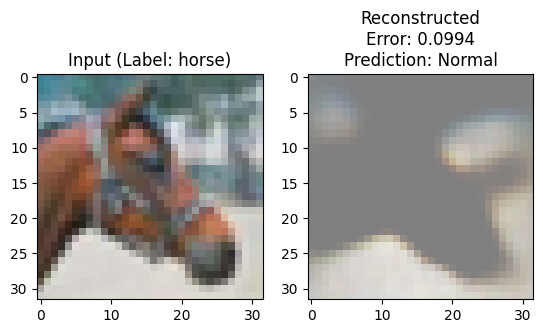

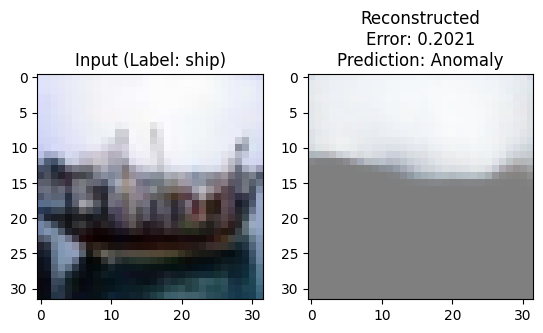

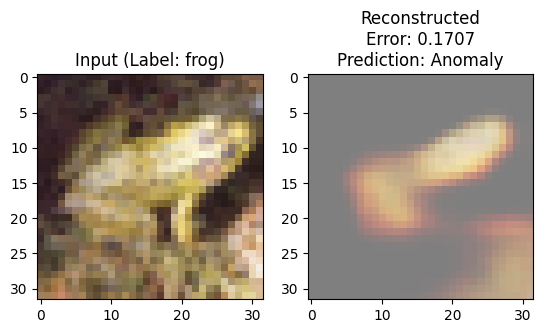

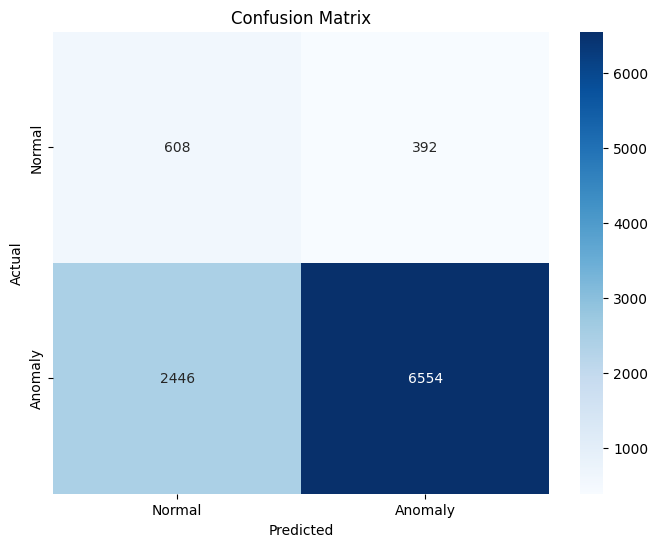

ROC AUC Score: 0.7264


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

# Define the Convolutional Encoder for CIFAR-10
class Encoder(nn.Module):
    def __init__(self, input_channels=3, latent_size=256):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(256 * 4 * 4, latent_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

# Define the Convolutional Decoder for CIFAR-10
class Decoder(nn.Module):
    def __init__(self, latent_size=256, output_channels=3):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Keep values between 0 and 1
        return x

# Define the Memory Module
class MemoryModule(nn.Module):
    def __init__(self, latent_size=256, memory_size=500):
        super(MemoryModule, self).__init__()
        self.memory = nn.Parameter(torch.randn(memory_size, latent_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, z):
        similarity = torch.matmul(z, self.memory.t()) / (torch.norm(z, dim=1, keepdim=True) * torch.norm(self.memory, dim=1))
        weights = self.softmax(similarity)
        z_hat = torch.matmul(weights, self.memory)
        return z_hat

# Define the MemAE model with Encoder, Decoder, and Memory
class MemAE(nn.Module):
    def __init__(self, input_channels=3, latent_size=256, memory_size=500):
        super(MemAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_size)
        self.memory_module = MemoryModule(latent_size, memory_size)
        self.decoder = Decoder(latent_size, input_channels)

    def forward(self, x):
        z = self.encoder(x)
        z_hat = self.memory_module(z)
        x_hat = self.decoder(z_hat)
        return x_hat

# Load CIFAR-10 dataset (only one class for training)
def load_cifar10_data(train=True, batch_size=64, class_label=0):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)

    # Filter out only the specified class for training
    indices = np.array(dataset.targets) == class_label
    dataset.data, dataset.targets = dataset.data[indices], np.array(dataset.targets)[indices]

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
def train_model(model, data_loader, num_epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in data_loader:
            inputs, _ = batch
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(data_loader):.4f}')

# CIFAR-10 class labels
CIFAR10_LABELS = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# Confusion Matrix Display
def display_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Test the model, classify samples, and generate confusion matrix
def test_model_with_confusion_matrix(model, test_loader, normal_class=0, threshold=0.1, show_samples=10):
    model.eval()
    all_labels = []
    all_errors = []
    predictions = []

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda() if torch.cuda.is_available() else inputs
        outputs = model(inputs)
        errors = torch.mean((outputs - inputs) ** 2, dim=[1, 2, 3])

        # Classify based on threshold
        for i in range(len(inputs)):
            error = errors[i].item()
            label = 1 if labels[i].item() != normal_class else 0  # 1: anomaly, 0: normal
            predicted = 1 if error > threshold else 0  # 1: anomaly, 0: normal

            # Collect predictions and true labels
            all_errors.append(error)
            all_labels.append(label)
            predictions.append(predicted)

            # Display images if needed
            if batch_idx * len(inputs) + i < show_samples:
                input_image = inputs[i].cpu().numpy().transpose(1, 2, 0)
                output_image = outputs[i].cpu().detach().numpy().transpose(1, 2, 0)
                class_label = CIFAR10_LABELS[labels[i].item()]
                anomaly_status = "Anomaly" if predicted == 1 else "Normal"

                fig, axarr = plt.subplots(1, 2)
                axarr[0].imshow((input_image * 0.5) + 0.5)
                axarr[0].set_title(f'Input (Label: {class_label})')
                axarr[1].imshow((output_image * 0.5) + 0.5)
                axarr[1].set_title(f'Reconstructed\nError: {error:.4f}\nPrediction: {anomaly_status}')
                plt.show()

    # Display confusion matrix
    display_confusion_matrix(all_labels, predictions)

    return all_labels, all_errors

# Evaluate model performance using ROC-AUC
def evaluate_model(labels, errors):
    auc_score = roc_auc_score(labels, errors)
    print(f'ROC AUC Score: {auc_score:.4f}')
    return auc_score

# Main execution
if __name__ == '__main__':
    # Initialize model
    model = MemAE(input_channels=3, latent_size=256, memory_size=500)
    model = model.cuda() if torch.cuda.is_available() else model

    # Load the dataset (train on class 0: airplane, test on all classes)
    train_loader = load_cifar10_data(train=True, class_label=0)
    test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                                                                 (0.5, 0.5, 0.5))])),
                             batch_size=64, shuffle=False)

    # Train the model
    train_model(model, train_loader, num_epochs=30)

    # Test the model on normal (class 0: airplane) and anomalous classes (other CIFAR-10 classes)
    labels, errors = test_model_with_confusion_matrix(model, test_loader, show_samples=20)

    # Evaluate the model
    evaluate_model(labels, errors)


## Training with 100 epochs

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100], Loss: 0.2483
Epoch [2/100], Loss: 0.1724
Epoch [3/100], Loss: 0.1523
Epoch [4/100], Loss: 0.1474
Epoch [5/100], Loss: 0.1427
Epoch [6/100], Loss: 0.1390
Epoch [7/100], Loss: 0.1366
Epoch [8/100], Loss: 0.1340
Epoch [9/100], Loss: 0.1305
Epoch [10/100], Loss: 0.1278
Epoch [11/100], Loss: 0.1252
Epoch [12/100], Loss: 0.1235
Epoch [13/100], Loss: 0.1221
Epoch [14/100], Loss: 0.1206
Epoch [15/100], Loss: 0.1199
Epoch [16/100], Loss: 0.1192
Epoch [17/100], Loss: 0.1182
Epoch [18/100], Loss: 0.1177
Epoch [19/100], Loss: 0.1172
Epoch [20/100], Loss: 0.1165
Epoch [21/100], Loss: 0.1153
Epoch [22/100], Loss: 0.1152
Epoch [23/100], Loss: 0.1145
Epoch [24/100], Loss: 0.1136
Epoch [25/100], Loss: 0.1131
Epoch [26/100], Loss: 0.1129
Epoch [27/100], Loss: 0.1123
Epoch [28/100], Loss: 0.1118
Epoch [29/100], Loss: 0.1112
Epoch [30/100], Loss: 0.1107
Epoch [31/100], Loss: 0.1109
Epoch [32/100], Loss: 0.1101
Epoch

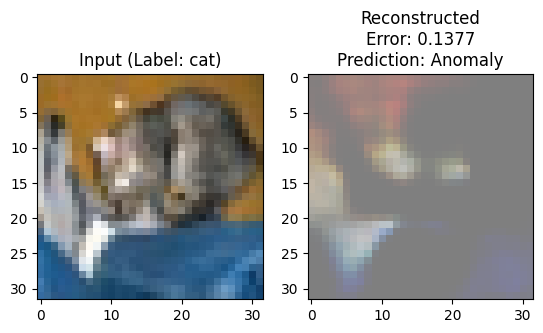

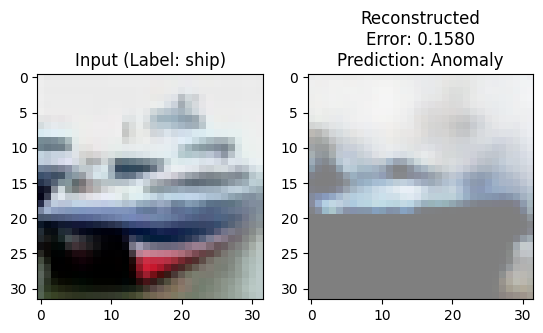

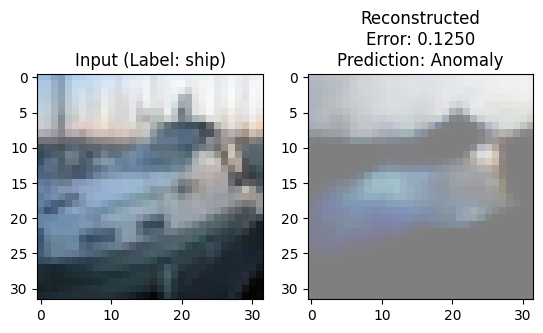

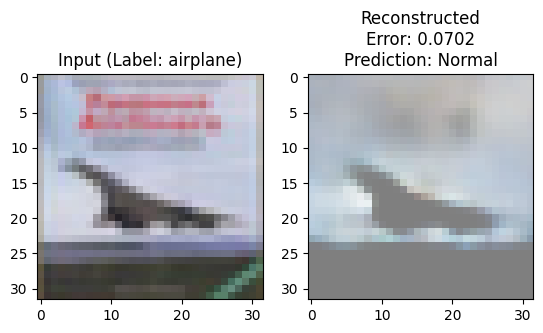

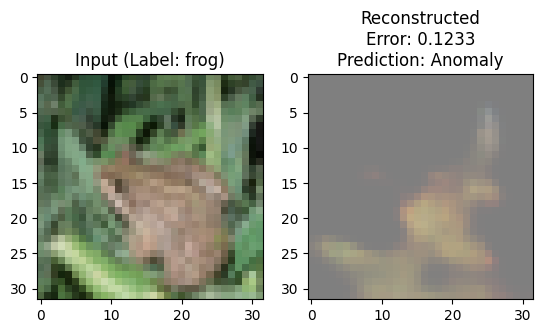

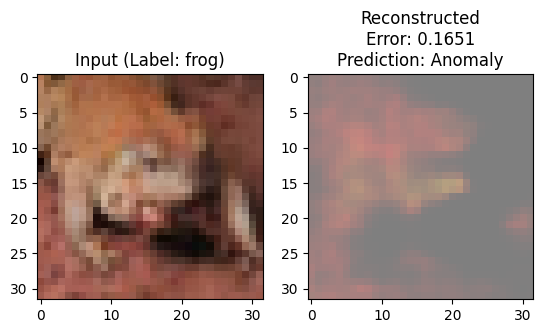

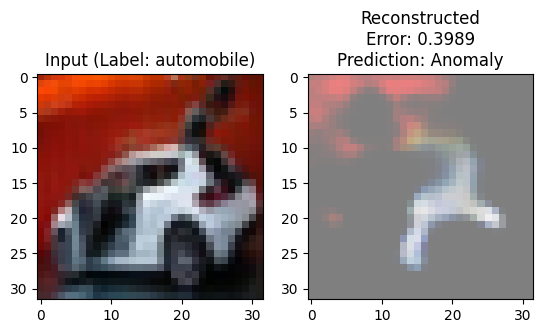

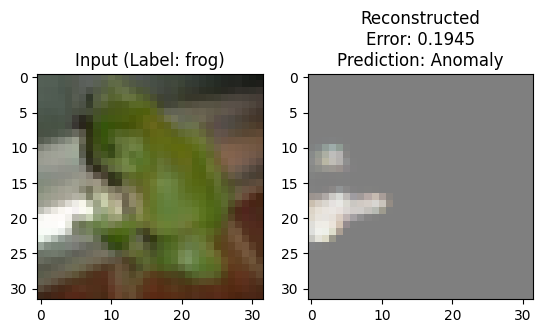

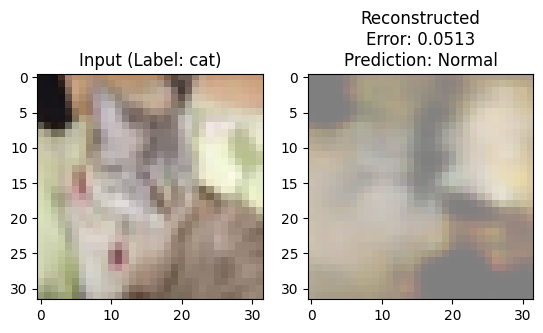

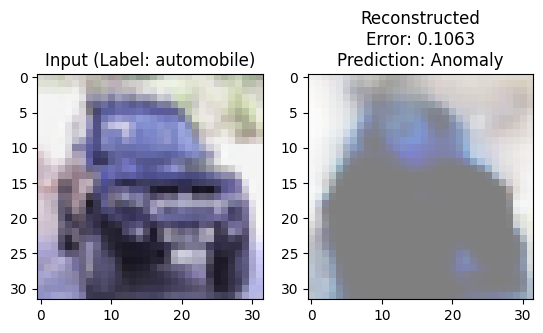

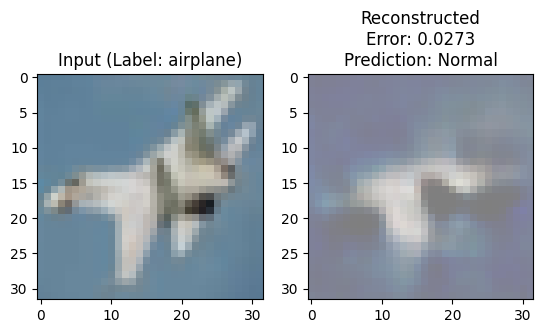

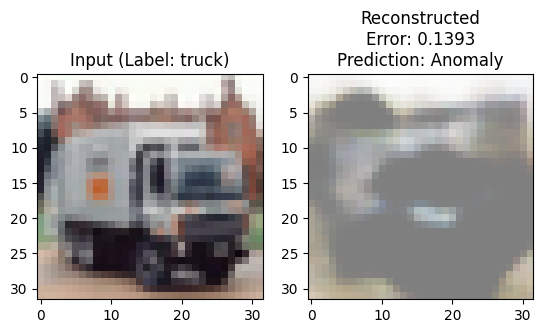

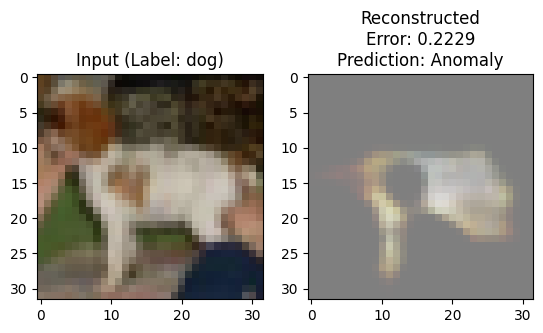

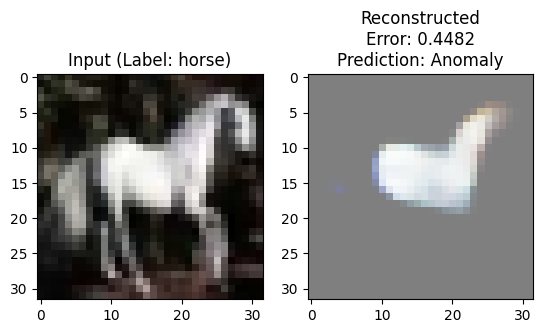

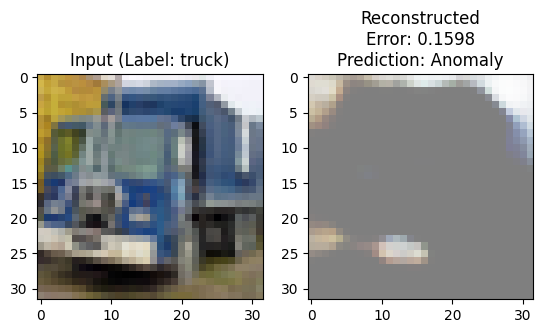

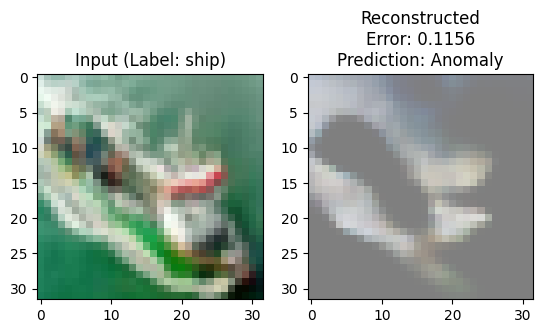

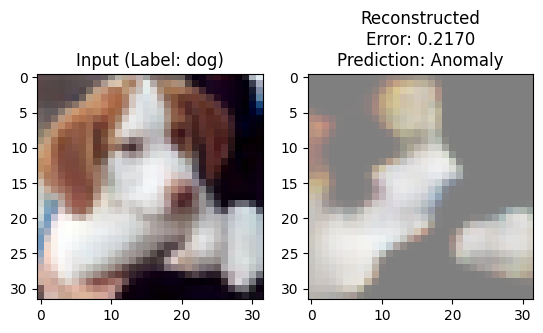

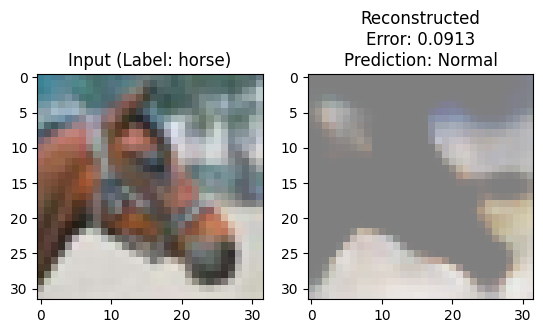

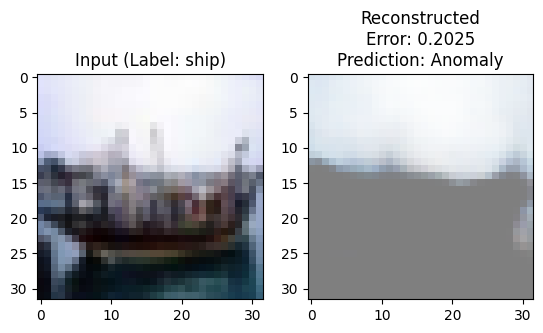

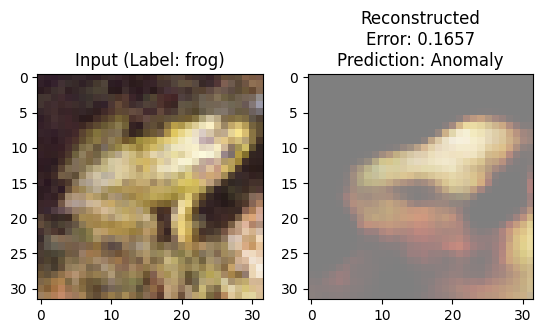

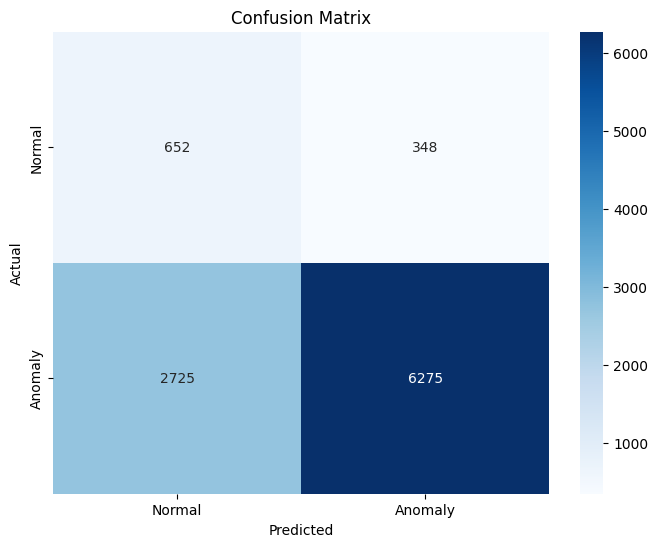

ROC AUC Score: 0.7304


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

# Define the Convolutional Encoder for CIFAR-10
class Encoder(nn.Module):
    def __init__(self, input_channels=3, latent_size=256):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(256 * 4 * 4, latent_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

# Define the Convolutional Decoder for CIFAR-10
class Decoder(nn.Module):
    def __init__(self, latent_size=256, output_channels=3):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Keep values between 0 and 1
        return x

# Define the Memory Module
class MemoryModule(nn.Module):
    def __init__(self, latent_size=256, memory_size=500):
        super(MemoryModule, self).__init__()
        self.memory = nn.Parameter(torch.randn(memory_size, latent_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, z):
        similarity = torch.matmul(z, self.memory.t()) / (torch.norm(z, dim=1, keepdim=True) * torch.norm(self.memory, dim=1))
        weights = self.softmax(similarity)
        z_hat = torch.matmul(weights, self.memory)
        return z_hat

# Define the MemAE model with Encoder, Decoder, and Memory
class MemAE(nn.Module):
    def __init__(self, input_channels=3, latent_size=256, memory_size=500):
        super(MemAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_size)
        self.memory_module = MemoryModule(latent_size, memory_size)
        self.decoder = Decoder(latent_size, input_channels)

    def forward(self, x):
        z = self.encoder(x)
        z_hat = self.memory_module(z)
        x_hat = self.decoder(z_hat)
        return x_hat

# Load CIFAR-10 dataset (only one class for training)
def load_cifar10_data(train=True, batch_size=64, class_label=0):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)

    # Filter out only the specified class for training
    indices = np.array(dataset.targets) == class_label
    dataset.data, dataset.targets = dataset.data[indices], np.array(dataset.targets)[indices]

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
def train_model(model, data_loader, num_epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in data_loader:
            inputs, _ = batch
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(data_loader):.4f}')

# CIFAR-10 class labels
CIFAR10_LABELS = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# Confusion Matrix Display
def display_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Test the model, classify samples, and generate confusion matrix
def test_model_with_confusion_matrix(model, test_loader, normal_class=0, threshold=0.1, show_samples=10):
    model.eval()
    all_labels = []
    all_errors = []
    predictions = []

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda() if torch.cuda.is_available() else inputs
        outputs = model(inputs)
        errors = torch.mean((outputs - inputs) ** 2, dim=[1, 2, 3])

        # Classify based on threshold
        for i in range(len(inputs)):
            error = errors[i].item()
            label = 1 if labels[i].item() != normal_class else 0  # 1: anomaly, 0: normal
            predicted = 1 if error > threshold else 0  # 1: anomaly, 0: normal

            # Collect predictions and true labels
            all_errors.append(error)
            all_labels.append(label)
            predictions.append(predicted)

            # Display images if needed
            if batch_idx * len(inputs) + i < show_samples:
                input_image = inputs[i].cpu().numpy().transpose(1, 2, 0)
                output_image = outputs[i].cpu().detach().numpy().transpose(1, 2, 0)
                class_label = CIFAR10_LABELS[labels[i].item()]
                anomaly_status = "Anomaly" if predicted == 1 else "Normal"

                fig, axarr = plt.subplots(1, 2)
                axarr[0].imshow((input_image * 0.5) + 0.5)
                axarr[0].set_title(f'Input (Label: {class_label})')
                axarr[1].imshow((output_image * 0.5) + 0.5)
                axarr[1].set_title(f'Reconstructed\nError: {error:.4f}\nPrediction: {anomaly_status}')
                plt.show()

    # Display confusion matrix
    display_confusion_matrix(all_labels, predictions)

    return all_labels, all_errors

# Evaluate model performance using ROC-AUC
def evaluate_model(labels, errors):
    auc_score = roc_auc_score(labels, errors)
    print(f'ROC AUC Score: {auc_score:.4f}')
    return auc_score

# Main execution
if __name__ == '__main__':
    # Initialize model
    model = MemAE(input_channels=3, latent_size=256, memory_size=500)
    model = model.cuda() if torch.cuda.is_available() else model

    # Load the dataset (train on class 0: airplane, test on all classes)
    train_loader = load_cifar10_data(train=True, class_label=0)
    test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                                                                 (0.5, 0.5, 0.5))])),
                             batch_size=64, shuffle=False)

    # Train the model
    train_model(model, train_loader, num_epochs=100)

    # Test the model on normal (class 0: airplane) and anomalous classes (other CIFAR-10 classes)
    labels, errors = test_model_with_confusion_matrix(model, test_loader, show_samples=20)

    # Evaluate the model
    evaluate_model(labels, errors)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 0.2327
Epoch [2/10], Loss: 0.1765
Epoch [3/10], Loss: 0.1651
Epoch [4/10], Loss: 0.1601
Epoch [5/10], Loss: 0.1540
Epoch [6/10], Loss: 0.1485
Epoch [7/10], Loss: 0.1463
Epoch [8/10], Loss: 0.1444
Epoch [9/10], Loss: 0.1429
Epoch [10/10], Loss: 0.1427


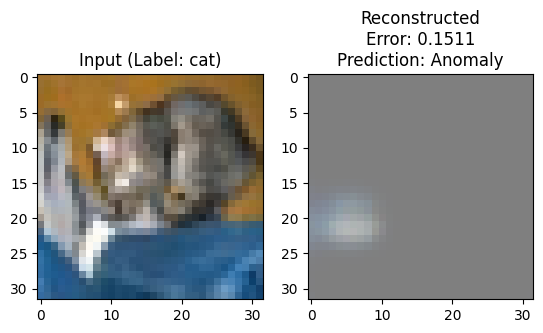

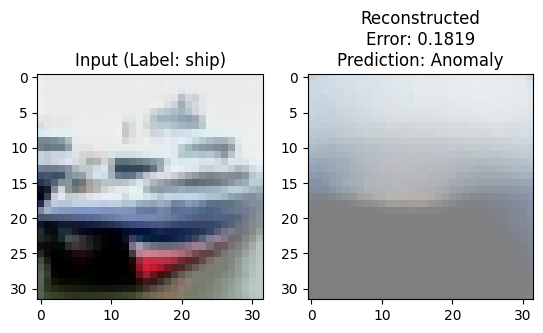

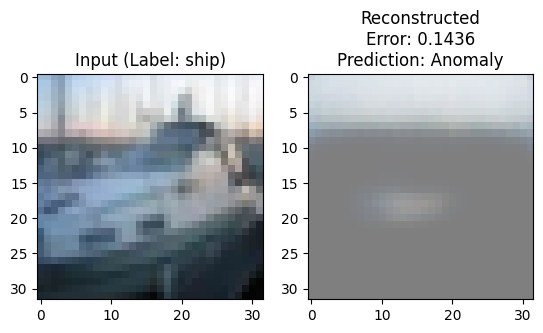

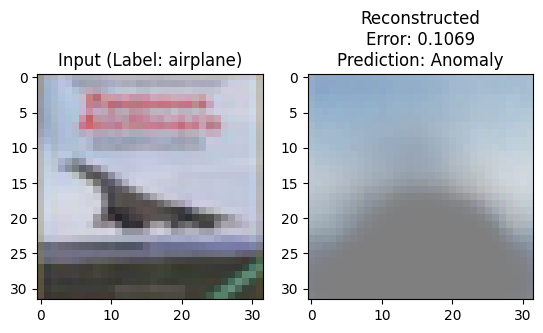

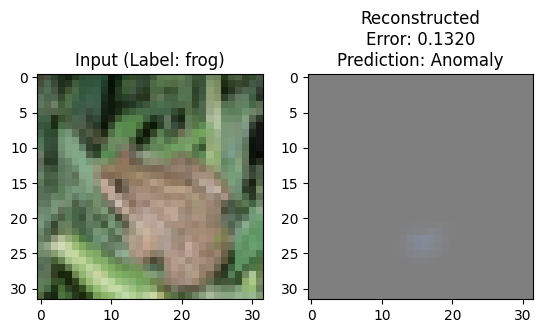

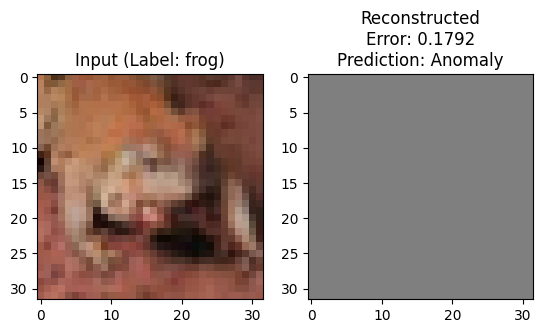

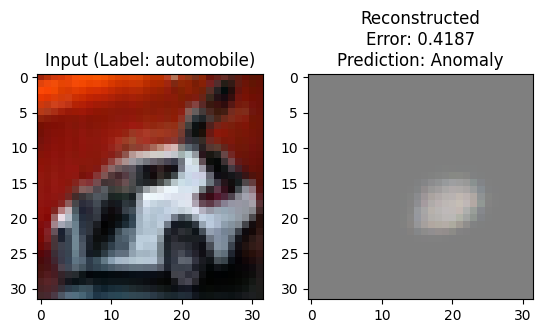

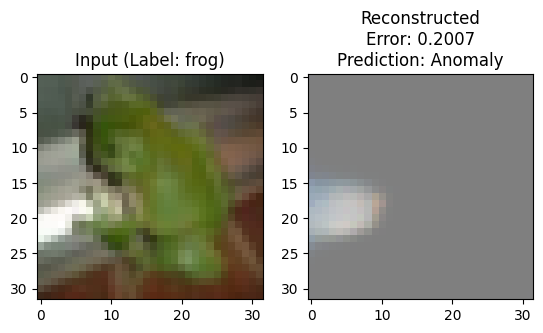

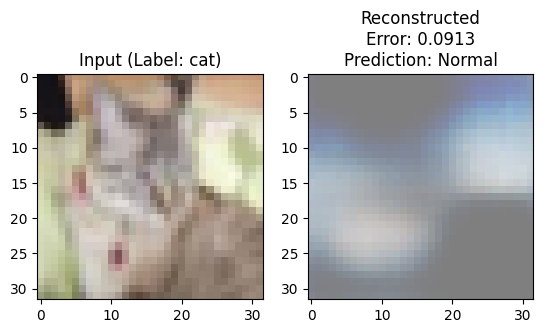

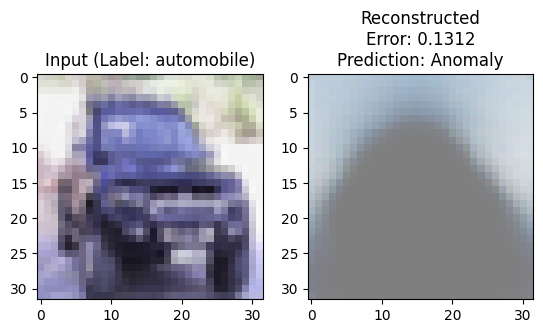

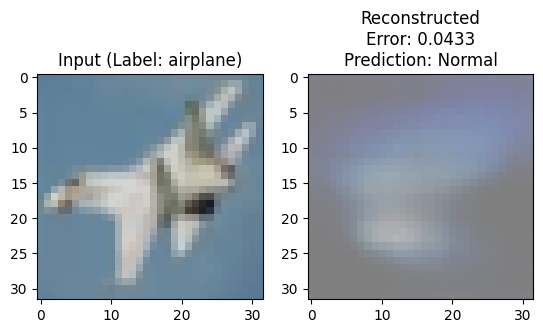

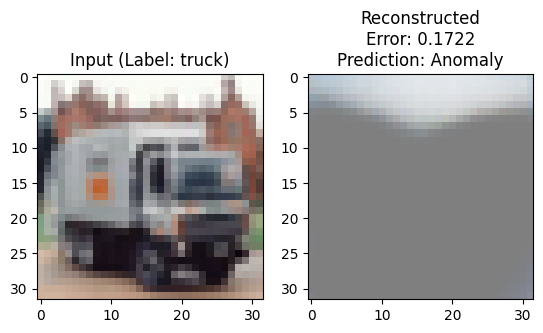

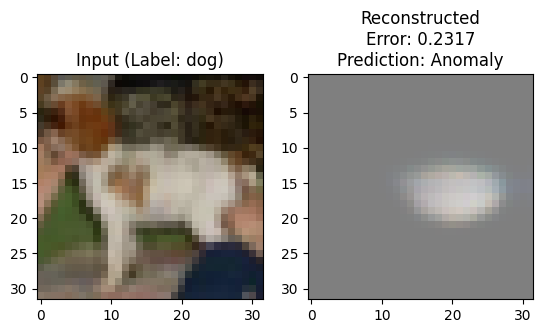

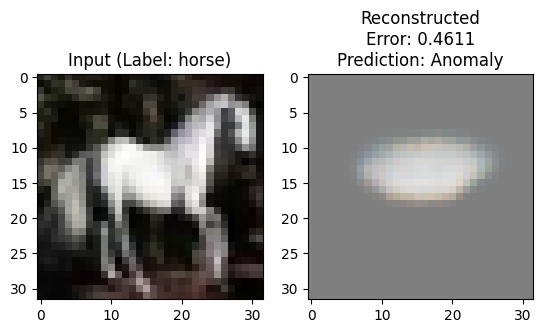

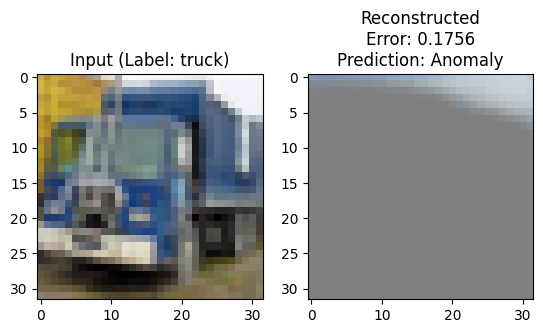

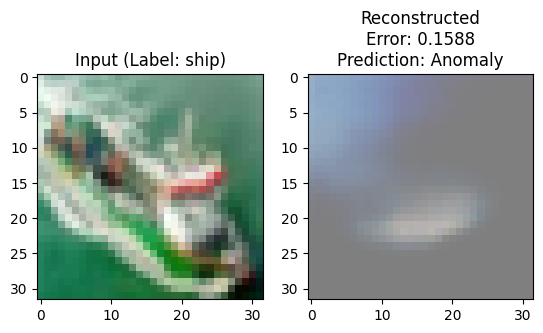

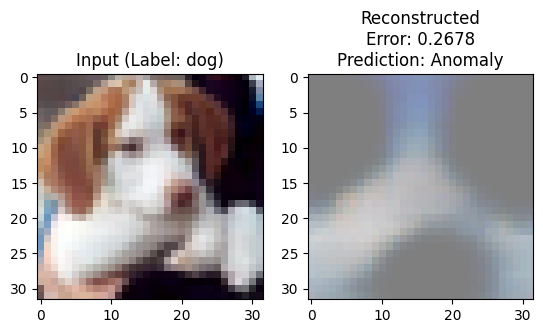

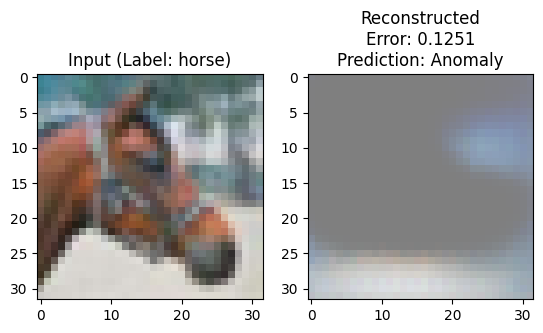

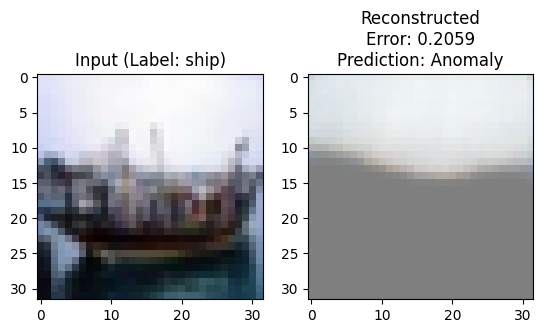

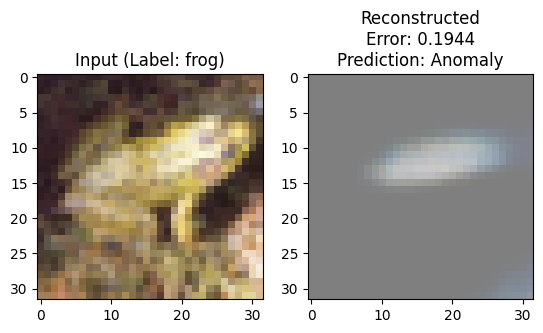

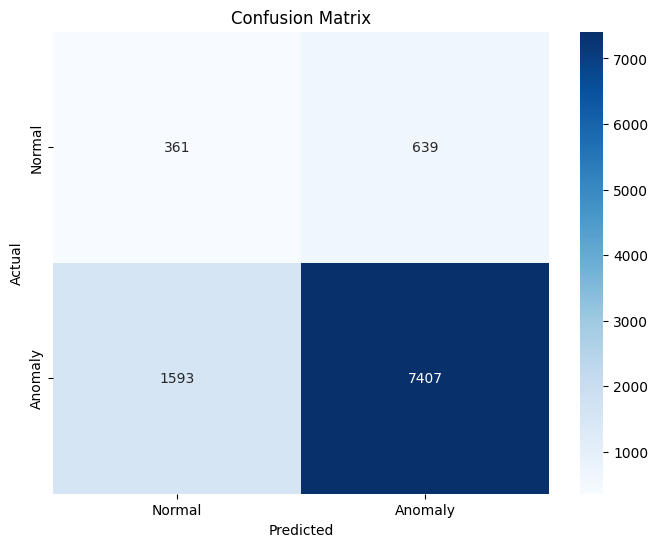

ROC AUC Score: 0.6487


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns

# Define the Convolutional Encoder for CIFAR-10
class Encoder(nn.Module):
    def __init__(self, input_channels=3, latent_size=256):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(256 * 4 * 4, latent_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        z = self.fc(x)
        return z

# Define the Convolutional Decoder for CIFAR-10
class Decoder(nn.Module):
    def __init__(self, latent_size=256, output_channels=3):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Keep values between 0 and 1
        return x

# Define the Memory Module
class MemoryModule(nn.Module):
    def __init__(self, latent_size=256, memory_size=500):
        super(MemoryModule, self).__init__()
        self.memory = nn.Parameter(torch.randn(memory_size, latent_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, z):
        similarity = torch.matmul(z, self.memory.t()) / (torch.norm(z, dim=1, keepdim=True) * torch.norm(self.memory, dim=1))
        weights = self.softmax(similarity)
        z_hat = torch.matmul(weights, self.memory)
        return z_hat

# Define the MemAE model with Encoder, Decoder, and Memory
class MemAE(nn.Module):
    def __init__(self, input_channels=3, latent_size=256, memory_size=500):
        super(MemAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_size)
        self.memory_module = MemoryModule(latent_size, memory_size)
        self.decoder = Decoder(latent_size, input_channels)

    def forward(self, x):
        z = self.encoder(x)
        z_hat = self.memory_module(z)
        x_hat = self.decoder(z_hat)
        return x_hat

# Load CIFAR-10 dataset (only one class for training)
def load_cifar10_data(train=True, batch_size=64, class_label=0):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)

    # Filter out only the specified class for training
    indices = np.array(dataset.targets) == class_label
    dataset.data, dataset.targets = dataset.data[indices], np.array(dataset.targets)[indices]

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
def train_model(model, data_loader, num_epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in data_loader:
            inputs, _ = batch
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(data_loader):.4f}')

# CIFAR-10 class labels
CIFAR10_LABELS = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# Confusion Matrix Display
def display_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Test the model, classify samples, and generate confusion matrix
def test_model_with_confusion_matrix(model, test_loader, normal_class=0, threshold=0.1, show_samples=10):
    model.eval()
    all_labels = []
    all_errors = []
    predictions = []

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda() if torch.cuda.is_available() else inputs
        outputs = model(inputs)
        errors = torch.mean((outputs - inputs) ** 2, dim=[1, 2, 3])

        # Classify based on threshold
        for i in range(len(inputs)):
            error = errors[i].item()
            label = 1 if labels[i].item() != normal_class else 0  # 1: anomaly, 0: normal
            predicted = 1 if error > threshold else 0  # 1: anomaly, 0: normal

            # Collect predictions and true labels
            all_errors.append(error)
            all_labels.append(label)
            predictions.append(predicted)

            # Display images if needed
            if batch_idx * len(inputs) + i < show_samples:
                input_image = inputs[i].cpu().numpy().transpose(1, 2, 0)
                output_image = outputs[i].cpu().detach().numpy().transpose(1, 2, 0)
                class_label = CIFAR10_LABELS[labels[i].item()]
                anomaly_status = "Anomaly" if predicted == 1 else "Normal"

                fig, axarr = plt.subplots(1, 2)
                axarr[0].imshow((input_image * 0.5) + 0.5)
                axarr[0].set_title(f'Input (Label: {class_label})')
                axarr[1].imshow((output_image * 0.5) + 0.5)
                axarr[1].set_title(f'Reconstructed\nError: {error:.4f}\nPrediction: {anomaly_status}')
                plt.show()

    # Display confusion matrix
    display_confusion_matrix(all_labels, predictions)

    return all_labels, all_errors

# Evaluate model performance using ROC-AUC
def evaluate_model(labels, errors):
    auc_score = roc_auc_score(labels, errors)
    print(f'ROC AUC Score: {auc_score:.4f}')
    return auc_score

# Main execution
if __name__ == '__main__':
    # Initialize model
    model = MemAE(input_channels=3, latent_size=256, memory_size=500)
    model = model.cuda() if torch.cuda.is_available() else model

    # Load the dataset (train on class 0: airplane, test on all classes)
    train_loader = load_cifar10_data(train=True, class_label=8)
    test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                                                                 (0.5, 0.5, 0.5))])),
                             batch_size=64, shuffle=False)

    # Train the model
    train_model(model, train_loader, num_epochs=10)

    # Test the model on normal (class 0: airplane) and anomalous classes (other CIFAR-10 classes)
    labels, errors = test_model_with_confusion_matrix(model, test_loader,normal_class=8, show_samples=20)

    # Evaluate the model
    evaluate_model(labels, errors)
